In [1]:
import numpy as np
from typing import SupportsIndex
from sklearn.metrics import accuracy_score, classification_report, f1_score
import matplotlib.pyplot as plt

# Classic KNN

Dataset shape: (290, 2) (290,)
Train/test shapes: (203, 2) (87, 2)
Accuracy for n_neighbors=1: 0.8391
Additional metric: 0.8270 [custom]
Accuracy for n_neighbors=2: 0.8506
Additional metric: 0.8304 [custom]
Accuracy for n_neighbors=3: 0.8276
Additional metric: 0.8158 [custom]
Accuracy for n_neighbors=4: 0.8506
Additional metric: 0.8359 [custom]
Accuracy for n_neighbors=5: 0.8391
Additional metric: 0.8310 [custom]
              precision    recall  f1-score   support

         0.0       0.94      0.81      0.87        57
         1.0       0.71      0.90      0.79        30

    accuracy                           0.84        87
   macro avg       0.82      0.85      0.83        87
weighted avg       0.86      0.84      0.84        87



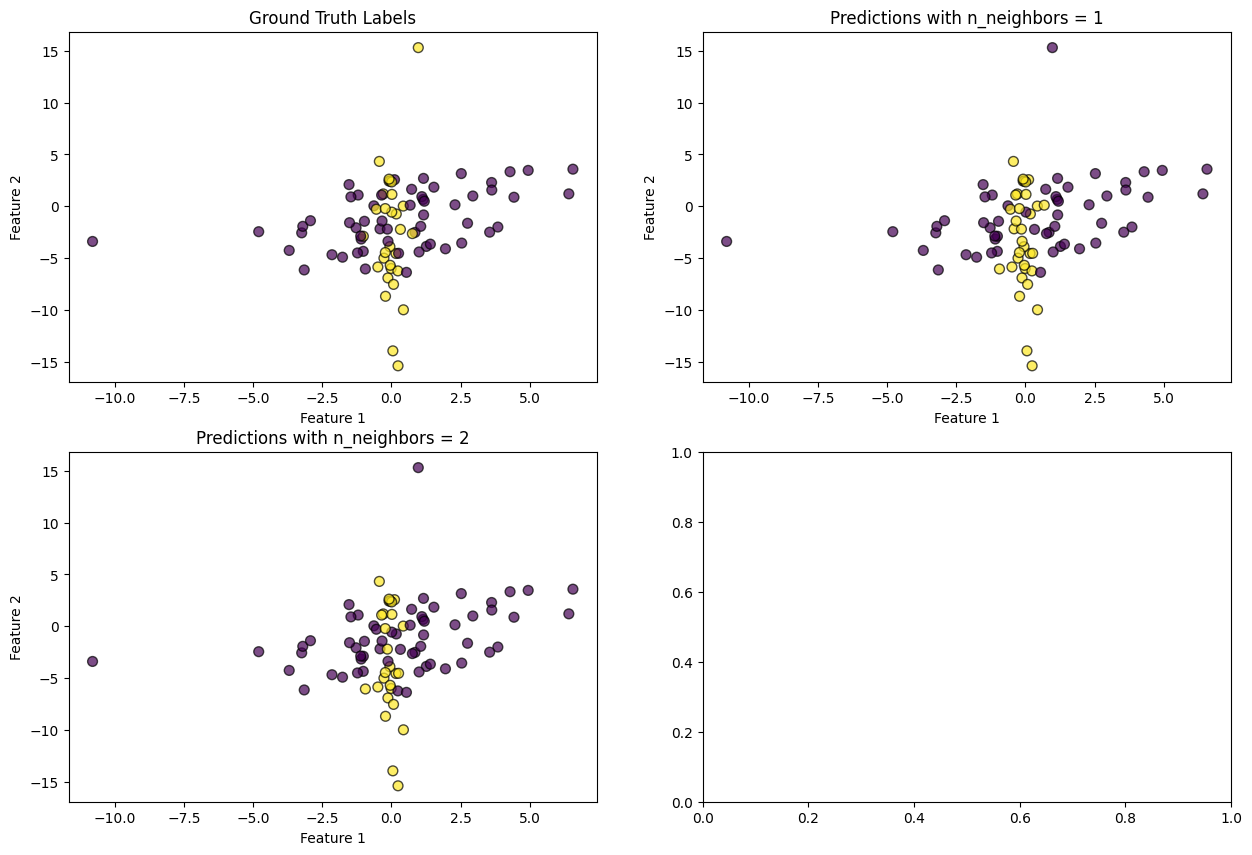

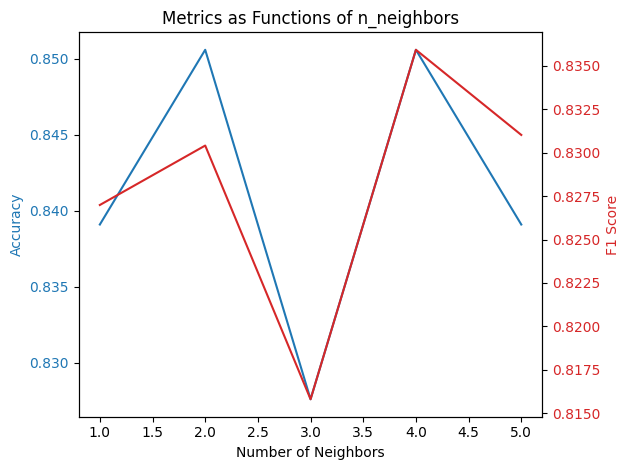

In [2]:
class KNN:
    """
    Class implementing the k-nearest neighbors algorithm.
    """

    def __init__(self, n_neighbors: int = 4):
        self.X_train = None
        self.y_train = None
        self.n_neighbors = n_neighbors

    def fit(self, X: np.ndarray, y: SupportsIndex):
        self.X_train = X
        self.y_train = y

    def predict(self, X: np.ndarray) -> np.ndarray:
        distances = np.linalg.norm(X[:, np.newaxis] - self.X_train, axis=2)
        nearest_indices = np.argsort(distances, axis=1)[:, :self.n_neighbors]
        nearest_labels = self.y_train[nearest_indices]
        return np.array([np.bincount(labels.astype(int)).argmax() for labels in nearest_labels])

def accuracy(labels_true: np.ndarray, labels_pred: np.ndarray) -> float:
    return np.mean(labels_true == labels_pred)

def metric(labels_true: np.ndarray, labels_pred: np.ndarray) -> float:
    classes = np.unique(labels_true)
    f1_scores = []

    for cls in classes:
        tp = np.sum((labels_true == cls) & (labels_pred == cls))
        fp = np.sum((labels_true != cls) & (labels_pred == cls))
        fn = np.sum((labels_true == cls) & (labels_pred != cls))

        if (2 * tp + fp + fn) > 0:
            f1 = (2 * tp) / (2 * tp + fp + fn)
        else:
            f1 = 0

        f1_scores.append(f1)

    return np.mean(f1_scores)

if __name__ == "__main__":

    np.random.seed(100)
    means0, covs0 = [1, -1], [[7, 3], [3, 7]]
    x0, y0 = np.random.multivariate_normal(means0, covs0, 190).T

    means1, covs1 = [0, -4], [[0.1, 0.0], [0.0, 25]]
    x1, y1 = np.random.multivariate_normal(means1, covs1, 100).T

    # Visualize the data (optional)
    # plt.plot(x0, y0, 'o', color='b')
    # plt.plot(x1, y1, 'o', color='r')
    # plt.show()

    # Convert data to the appropriate format
    data0, labels0 = np.vstack([x0, y0]).T, np.zeros(len(x0))
    data1, labels1 = np.vstack([x1, y1]).T, np.ones(len(x1))

    data = np.vstack([data0, data1])
    labels = np.hstack([labels0, labels1])
    total_size = data.shape[0]
    print("Dataset shape:", data.shape, labels.shape)

    # Split dataset into 70% train and 30% test
    train_size = int(total_size * 0.7)
    indices = np.random.permutation(total_size)
    X_train, y_train = data[indices][:train_size], labels[indices][:train_size]
    X_test, y_test = data[indices][train_size:], labels[indices][train_size:]
    print("Train/test shapes:", X_train.shape, X_test.shape)


    accuracies = []
    f1_scores = []

    for n in range(1, 6):
        predictor = KNN(n_neighbors=n)
        predictor.fit(X_train, y_train)
        y_pred = predictor.predict(X_test)

        acc = accuracy(y_test, y_pred)
        accuracies.append(acc)
        f1 = metric(y_test, y_pred)
        f1_scores.append(f1)

        print(f"Accuracy for n_neighbors={n}: {acc:.4f}")
        assert abs(accuracy_score(y_test, y_pred) - acc) < 1e-5, "Implemented accuracy is not the same as sci-kit learn one!"
        
        assert accuracy_score(y_test, y_pred) > 190. / 290., "Your classifier is worse than the constant !"
        
        print("Additional metric: %.4f [custom]" % f1)
        assert abs(f1 - f1_score(y_test, y_pred, average='macro')) < 1e-5, "Custom metric does not match sklearn metric!"
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', edgecolor='k', s=50, alpha=0.7)
    plt.title('Ground Truth Labels')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    predictor = KNN(n_neighbors=1)
    predictor.fit(X_train, y_train)
    y_pred_1 = predictor.predict(X_test)
    plt.subplot(2, 2, 2)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_1, cmap='viridis', edgecolor='k', s=50, alpha=0.7)
    plt.title('Predictions with n_neighbors = 1')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    best_n = np.argmax(accuracies) + 1 
    predictor = KNN(n_neighbors=best_n)
    predictor.fit(X_train, y_train)
    y_pred_best = predictor.predict(X_test)
    plt.subplot(2, 2, 3)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_best, cmap='viridis', edgecolor='k', s=50, alpha=0.7)
    plt.title(f'Predictions with n_neighbors = {best_n}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    plt.subplot(2, 2, 4)
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Number of Neighbors')
    ax1.set_ylabel('Accuracy', color='tab:blue')
    ax1.plot(range(1, 6), accuracies, color='tab:blue', label='Accuracy')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('F1 Score', color='tab:red')  
    ax2.plot(range(1, 6), f1_scores, color='tab:red', label='F1 Score')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title('Metrics as Functions of n_neighbors')
    fig.tight_layout()

# KNN with using KDTree

In [3]:
from typing import List, Tuple

class KDNode:
    def __init__(self, point: np.ndarray, left=None, right=None):
        self.point = point 
        self.left = left   
        self.right = right  

class KDTree:
    def __init__(self, points: np.ndarray):
        self.root = self.build_kd_tree(points)

    def build_kd_tree(self, points: np.ndarray, depth: int = 0) -> KDNode:
        if len(points) == 0:
            return None

        k = points.shape[1] 
        axis = depth % k

        points = points[points[:, axis].argsort()]
        median = len(points) // 2

        return KDNode(
            point=points[median],
            left=self.build_kd_tree(points[:median], depth + 1),
            right=self.build_kd_tree(points[median + 1:], depth + 1)
        )

    def nearest_neighbor(self, root: KDNode, point: np.ndarray, depth: int = 0, best=None) -> Tuple[np.ndarray, float]:
        if root is None:
            return best

        dist = np.linalg.norm(point - root.point)
        if best is None or dist < best[1]:
            best = (root.point, dist)

        k = point.shape[0]
        axis = depth % k

        if point[axis] < root.point[axis]:
            best = self.nearest_neighbor(root.left, point, depth + 1, best)
            if best is None or abs(point[axis] - root.point[axis]) < best[1]:
                best = self.nearest_neighbor(root.right, point, depth + 1, best)
        else:
            best = self.nearest_neighbor(root.right, point, depth + 1, best)
            if best is None or abs(point[axis] - root.point[axis]) < best[1]:
                best = self.nearest_neighbor(root.left, point, depth + 1, best)

        return best

class KNN_KDTREE(KNN):
    def fit(self, X: np.ndarray, y: np.ndarray):
        self.X_train = X
        self.y_train = y
        self.tree = KDTree(X)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predictions = []
        for point in X:
            neighbors = []
            for _ in range(self.n_neighbors):
                neighbor, _ = self.tree.nearest_neighbor(self.tree.root, point)
                neighbors.append(neighbor)
                self.tree.root = self.remove_node(self.tree.root, neighbor)

            neighbor_labels = self.y_train[np.isin(self.X_train, neighbors).all(axis=1)]
            predictions.append(np.bincount(neighbor_labels).argmax())
        return np.array(predictions)

if __name__ == "__main__":
    import matplotlib.pyplot as plt

    data0, labels0 = np.vstack([x0, y0]).T, np.zeros(len(x0))
    data1, labels1 = np.vstack([x1, y1]).T, np.ones(len(x1))

    data = np.vstack([data0, data1])
    labels = np.hstack([labels0, labels1])
    total_size = data.shape[0]
    print("Dataset shape:", data.shape, labels.shape)

    # Split dataset into 70% train and 30% test
    train_size = int(total_size * 0.7)
    indices = np.random.permutation(total_size)
    X_train, y_train = data[indices][:train_size], labels[indices][:train_size]
    X_test, y_test = data[indices][train_size:], labels[indices][train_size:]
    print("Train/test shapes:", X_train.shape, X_test.shape)

    for n in range(1, 6):
        predictor = KNN(n_neighbors=n)
        predictor.fit(X_train, y_train)
        y_pred = predictor.predict(X_test)
        print(f"Accuracy for n_neighbors={n}: {accuracy(y_test, y_pred):.4f}")

        print("Accuracy: %.4f [ours]" % accuracy(y_test, y_pred))
        assert abs(accuracy_score(y_test, y_pred) - accuracy(y_test, y_pred)) < 1e-5,\
            "Implemented accuracy is not the same as sci-kit learn one!"

        assert accuracy_score(y_test, y_pred) > 190. / 290., "Your classifier is worse than the constant !"

        print("Additional metric: %.4f [custom]" % metric(y_test, y_pred))
        assert abs(metric(y_test, y_pred) - f1_score(y_test, y_pred, average= 'macro')) < 1e-5, \
            "Custom metric does not match sklearn metric!"

    print(classification_report(y_test, y_pred))
    plt.figure(figsize=(15, 10))

Dataset shape: (290, 2) (290,)
Train/test shapes: (203, 2) (87, 2)
Accuracy for n_neighbors=1: 0.9195
Accuracy: 0.9195 [ours]
Additional metric: 0.9167 [custom]
Accuracy for n_neighbors=2: 0.9080
Accuracy: 0.9080 [ours]
Additional metric: 0.9011 [custom]
Accuracy for n_neighbors=3: 0.9080
Accuracy: 0.9080 [ours]
Additional metric: 0.9034 [custom]
Accuracy for n_neighbors=4: 0.8736
Accuracy: 0.8736 [ours]
Additional metric: 0.8649 [custom]
Accuracy for n_neighbors=5: 0.9080
Accuracy: 0.9080 [ours]
Additional metric: 0.9034 [custom]
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92        51
         1.0       0.94      0.83      0.88        36

    accuracy                           0.91        87
   macro avg       0.91      0.90      0.90        87
weighted avg       0.91      0.91      0.91        87



<Figure size 1500x1000 with 0 Axes>